In [ ]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Bidirectional, LSTM, Dense, Softmax, TimeDistributed, Lambda, concatenate, GlobalAveragePooling1D, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, BatchNormalization, ELU
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
features = np.load('/content/drive/MyDrive/all_mfcc_features.npy')
features173 = np.load('/content/drive/MyDrive/all_mfcc_features_173.npy')
features86 = np.load('/content/drive/MyDrive/all_mfcc_features_86.npy')
features43 = np.load('/content/drive/MyDrive/all_mfcc_features_43.npy')
labels = np.load('/content/drive/MyDrive/labels.npy')

In [7]:
print(features43.shape)
print(features173.shape)
print(features86.shape)
print(features.shape)
print(labels.shape)

(1440, 128, 43)
(1440, 128, 173)
(1440, 128, 86)
(1440, 128, 347)
(1440,)


## Bar chart: the number of observation per emotion.

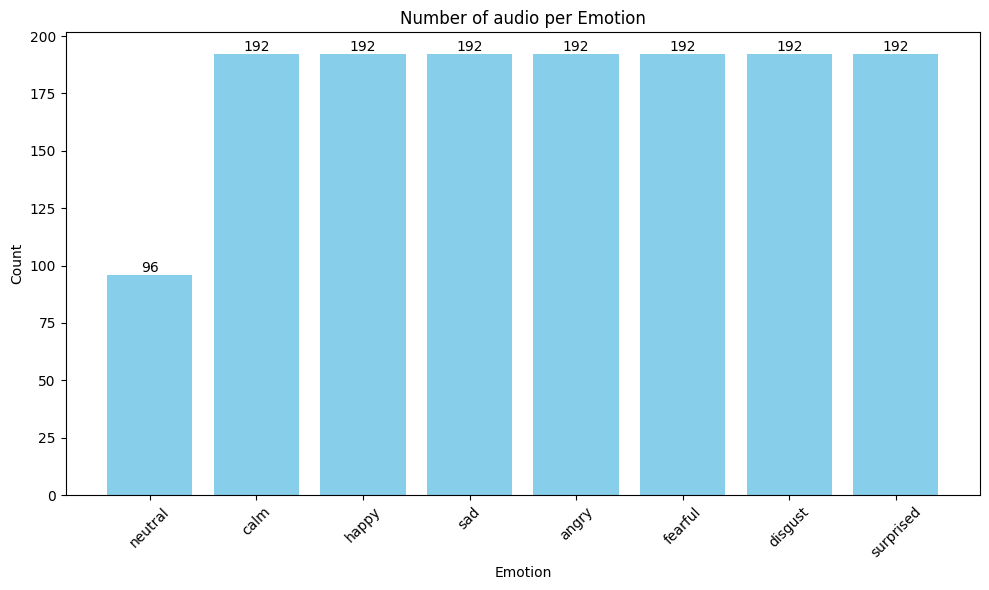

In [8]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue')

plt.title('Number of audio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


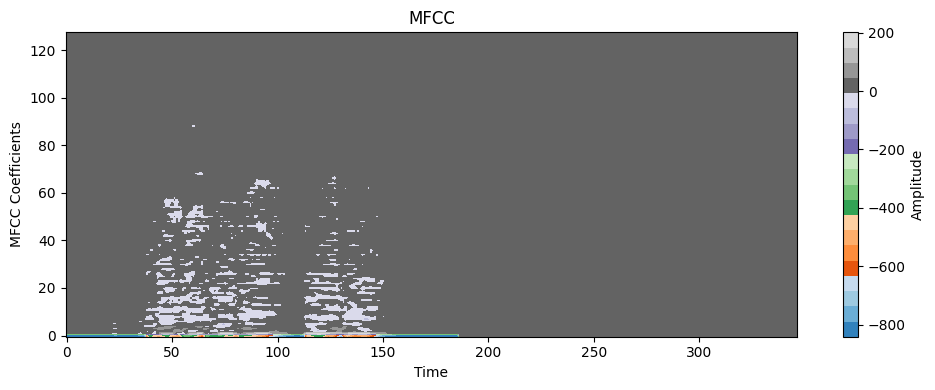

In [9]:
mfcc = features[500]

# Plotting the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfcc, aspect='auto', origin='lower', cmap='tab20c')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [10]:
# Convert labels vector
labels = labels - 1
labels = to_categorical(labels, num_classes=8)

#70:15:15 for feature (1440, 128, 347)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    features, labels, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42
)

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [11]:
#70:15:15 split for feature (1440, 128, 43)
X_train_val43, X_test43, y_train_val43, y_test43 = train_test_split(
    features43, labels, test_size=0.15, random_state=42
)

X_train43, X_val43, y_train43, y_val43 = train_test_split(
    X_train_val43, y_train_val43, test_size=0.1765, random_state=42
)

X_train43 = X_train43[..., np.newaxis]
X_val43 = X_val43[..., np.newaxis]
X_test43 = X_test43[..., np.newaxis]

In [12]:
#70:15:15 split for feature (1440, 128, 173)
X_train_val173, X_test173, y_train_val173, y_test173 = train_test_split(
    features173, labels, test_size=0.15, random_state=42
)

X_train173, X_val173, y_train173, y_val173 = train_test_split(
    X_train_val173, y_train_val173, test_size=0.1765, random_state=42
)

X_train173 = X_train173[..., np.newaxis]
X_val173 = X_val173[..., np.newaxis]
X_test173 = X_test173[..., np.newaxis]

In [13]:
#70:15:15 split for feature (1440, 128, 86)
X_train_val86, X_test86, y_train_val86, y_test86 = train_test_split(
    features86, labels, test_size=0.15, random_state=42
)

X_train86, X_val86, y_train86, y_val86 = train_test_split(
    X_train_val86, y_train_val86, test_size=0.1765, random_state=42
)

X_train86 = X_train86[..., np.newaxis]
X_val86 = X_val86[..., np.newaxis]
X_test86 = X_test86[..., np.newaxis]


# CNN

## CNN optimizer test(347)

In [ ]:
def base_cnn(optimizer):
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 5)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))  # 8-class classification problem

    if optimizer == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)
    elif optimizer == 'Adagrad':
        opt = optimizers.Adagrad()
    elif optimizer == 'Adam':
        opt = optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_145 (B  (None, 128, 347, 1)       4         
 atchNormalization)                                              
                                                                 
 conv2d_114 (Conv2D)         (None, 128, 347, 64)      640       
                                                                 
 batch_normalization_146 (B  (None, 128, 347, 64)      256       
 atchNormalization)                                              
                                                                 
 elu_131 (ELU)               (None, 128, 347, 64)      0         
                                                                 
 max_pooling2d_113 (MaxPool  (None, 64, 173, 64)       0         
 ing2D)                                                          
                                                     

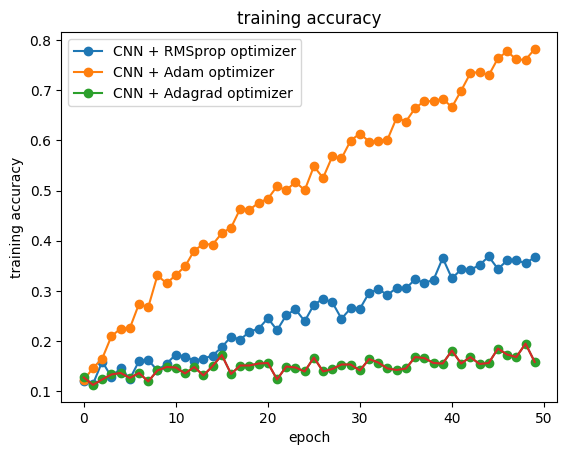

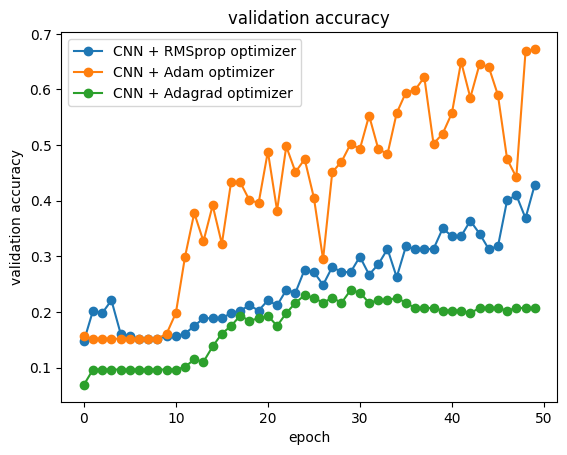

7/7 [==============================] - 1s 43ms/step - loss: 1.5695 - accuracy: 0.3704
Test accuracy for CNN + RMSprop optimizer: 0.37037035822868347
7/7 [==============================] - 1s 41ms/step - loss: 0.9872 - accuracy: 0.6852
Test accuracy for CNN + Adam optimizer: 0.6851851940155029
7/7 [==============================] - 0s 37ms/step - loss: 2.0915 - accuracy: 0.1759
Test accuracy for CNN + Adagrad optimizer: 0.17592592537403107


In [ ]:
history_opt = dict()

batch_size = 32
epochs = 50

for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  save_best_model = ModelCheckpoint('best_model.{}'.format(optimizer), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model = base_cnn(optimizer)
  history_opt[optimizer] = model.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_val, y_val),
                          shuffle=True,
                          callbacks=[save_best_model])

# Plot training accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  saved_model = load_model('best_model.{}'.format(optimizer))
  scores = saved_model.evaluate(X_test, y_test, verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(optimizer, scores[1]))

## CNN ADAM(347)

In [ ]:
def base_cnn_ADAM():
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 5)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))  # 8-class classification problem

    # Compile the model (Assuming a categorical classification problem)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary to verify the architecture
    print(model.summary())
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 128, 347, 1)       4         
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 347, 64)      640       
                                                                 
 batch_normalization_7 (Bat  (None, 128, 347, 64)      256       
 chNormalization)                                                
                                                                 
 elu_6 (ELU)                 (None, 128, 347, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 173, 64)       0         
 g2D)                                                            
                                                      

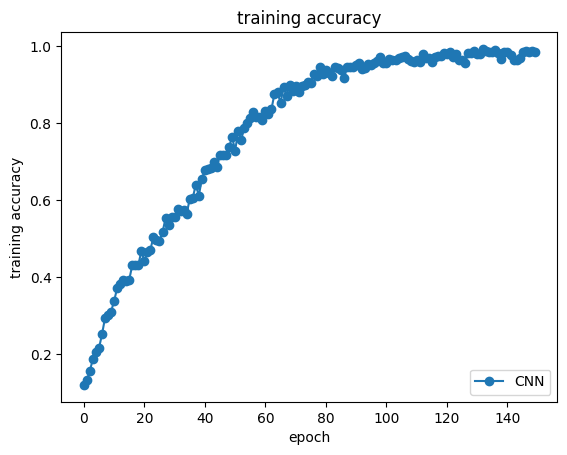

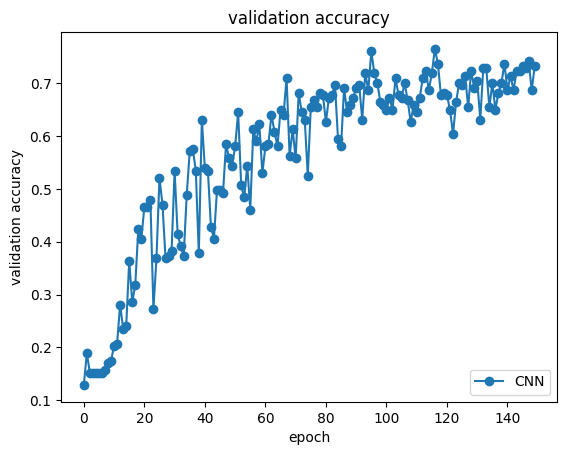

7/7 [==============================] - 1s 42ms/step - loss: 1.0537 - accuracy: 0.7176
Test accuracy: 0.7175925970077515


In [ ]:
# create a callback that will save the best model while training
history_activations = dict()
batch_size = 32
epochs = 150

save_best_model = ModelCheckpoint('best_model_cnn_347', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_cnn_ADAM()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val), shuffle=True,
                    callbacks=[save_best_model])

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='CNN')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy

plt.plot(history.history['val_accuracy'], 'o-', label='CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set/
saved_model = load_model('best_model_cnn_347')
scores = saved_model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy: {}'.format(scores[1]))

7/7 [==============================] - 1s 42ms/step


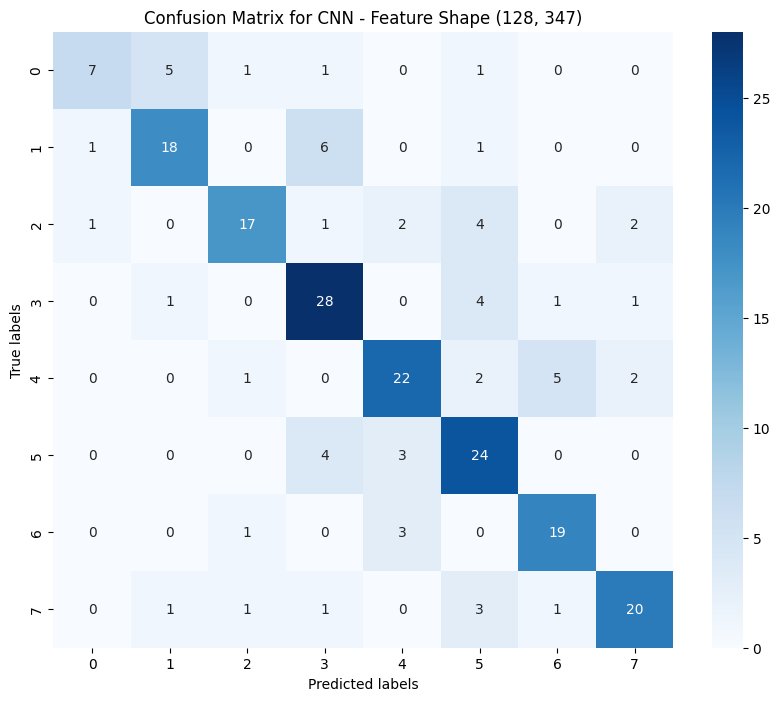

7/7 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

     neutral       0.78      0.47      0.58        15
        calm       0.72      0.69      0.71        26
       happy       0.81      0.63      0.71        27
         sad       0.68      0.80      0.74        35
       angry       0.73      0.69      0.71        32
     fearful       0.62      0.77      0.69        31
     disgust       0.73      0.83      0.78        23
   surprised       0.80      0.74      0.77        27

    accuracy                           0.72       216
   macro avg       0.73      0.70      0.71       216
weighted avg       0.73      0.72      0.72       216



In [ ]:
#Confusion matrix, table of Precision, Recall, and F1 Score
# Load the best saved model
saved_model = load_model('best_model_cnn_347')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 347)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)


## CNN (173)

In [ ]:
def base_cnn_ADAM_173():
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train173.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 5)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))  # 8-class classification problem

    # Compile the model (Assuming a categorical classification problem)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary to verify the architecture
    print(model.summary())
    return model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_53 (Ba  (None, 128, 173, 1)       4         
 tchNormalization)                                               
                                                                 
 conv2d_44 (Conv2D)          (None, 128, 173, 64)      640       
                                                                 
 batch_normalization_54 (Ba  (None, 128, 173, 64)      256       
 tchNormalization)                                               
                                                                 
 elu_53 (ELU)                (None, 128, 173, 64)      0         
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 64, 86, 64)        0         
 ng2D)                                                           
                                                     

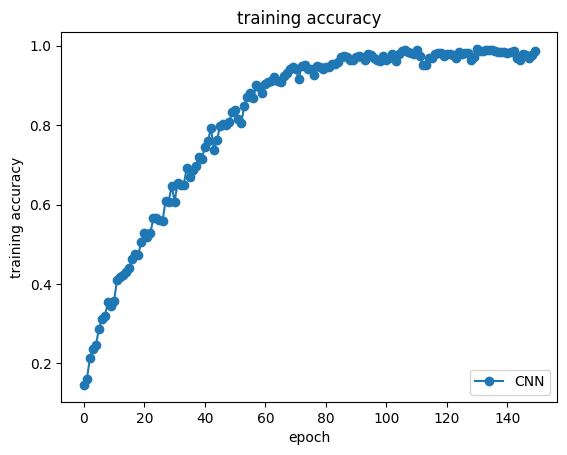

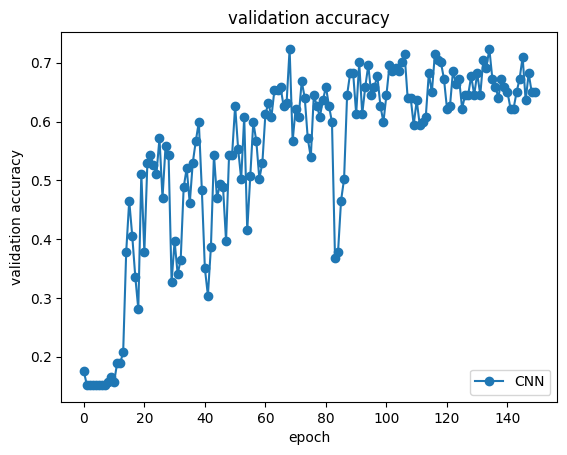

7/7 [==============================] - 1s 137ms/step - loss: 0.9178 - accuracy: 0.7130
Test accuracy: 0.7129629850387573


In [ ]:
# create a callback that will save the best model while training
history_activations = dict()
batch_size = 32
epochs = 150

save_best_model = ModelCheckpoint('best_model_cnn_173', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_cnn_ADAM_173()
history = model.fit(X_train173, y_train173, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val173, y_val173), shuffle=True,
                    callbacks=[save_best_model])

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='CNN')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy

plt.plot(history.history['val_accuracy'], 'o-', label='CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set/
saved_model = load_model('best_model_cnn_173')
scores = saved_model.evaluate(X_test173, y_test173, verbose=1)
print('Test accuracy: {}'.format(scores[1]))

7/7 [==============================] - 0s 21ms/step


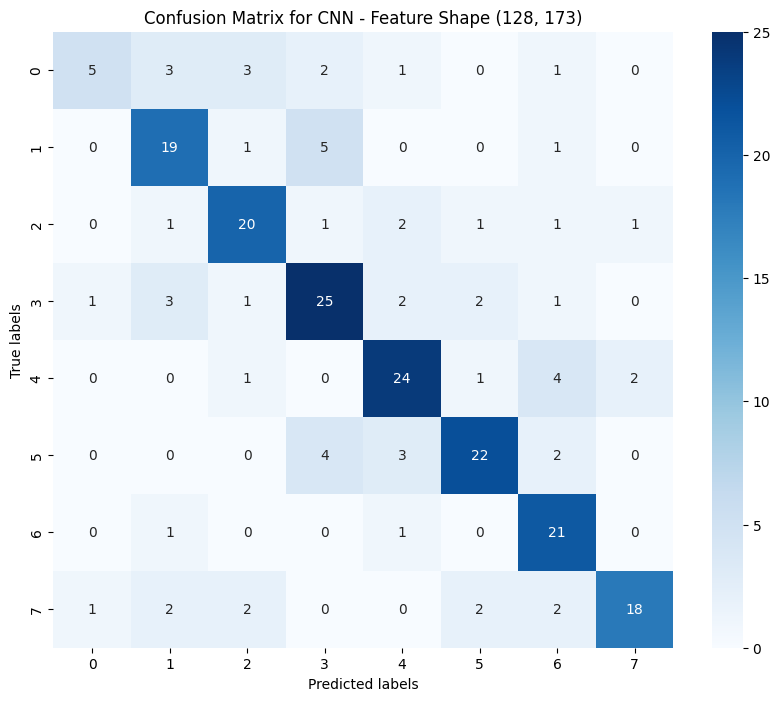

7/7 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

     neutral       0.71      0.33      0.45        15
        calm       0.66      0.73      0.69        26
       happy       0.71      0.74      0.73        27
         sad       0.68      0.71      0.69        35
       angry       0.73      0.75      0.74        32
     fearful       0.79      0.71      0.75        31
     disgust       0.64      0.91      0.75        23
   surprised       0.86      0.67      0.75        27

    accuracy                           0.71       216
   macro avg       0.72      0.69      0.69       216
weighted avg       0.72      0.71      0.71       216



In [ ]:
#Confusion matrix, table of Precision, Recall, and F1 Score
# Load the best saved model
saved_model = load_model('best_model_cnn_173')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test173)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 173)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test173)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

## CNN(86)

In [ ]:
def base_cnn_ADAM_86():
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train86.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(16))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))    # 8-class classification problem

    # Compile the model (Assuming a categorical classification problem)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary to verify the architecture
    print(model.summary())

    return model

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_75 (Ba  (None, 128, 86, 1)        4         
 tchNormalization)                                               
                                                                 
 conv2d_62 (Conv2D)          (None, 128, 86, 64)       640       
                                                                 
 batch_normalization_76 (Ba  (None, 128, 86, 64)       256       
 tchNormalization)                                               
                                                                 
 elu_74 (ELU)                (None, 128, 86, 64)       0         
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 64, 43, 64)        0         
 ng2D)                                                           
                                                     

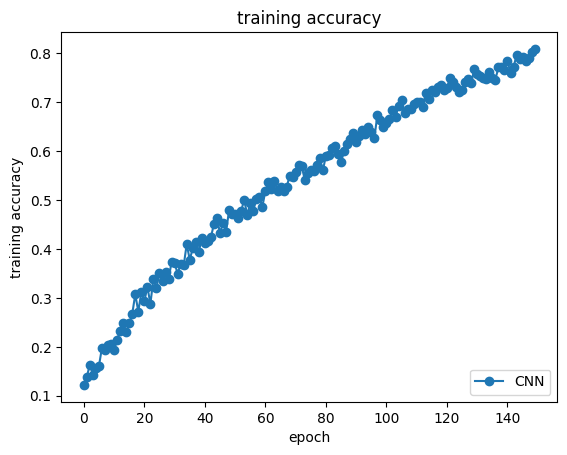

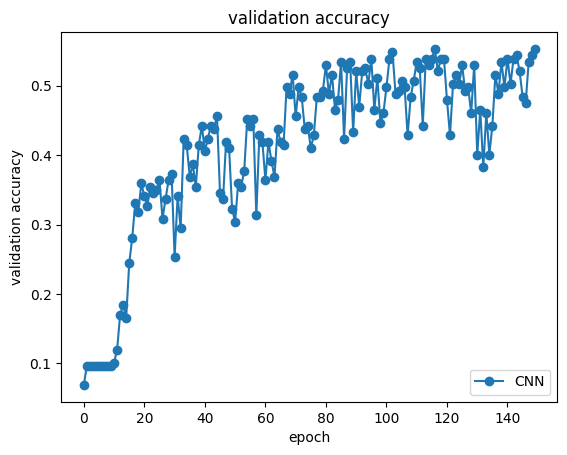

7/7 [==============================] - 1s 82ms/step - loss: 1.2400 - accuracy: 0.5972
Test accuracy: 0.5972222089767456


In [ ]:
# create a callback that will save the best model while training
history_activations = dict()
batch_size = 32
epochs = 150

save_best_model = ModelCheckpoint('best_model_cnn_86', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_cnn_ADAM_86()
history = model.fit(X_train86, y_train86, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val86, y_val86), shuffle=True,
                    callbacks=[save_best_model])

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='CNN')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy

plt.plot(history.history['val_accuracy'], 'o-', label='CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set/
saved_model = load_model('best_model_cnn_86')
scores = saved_model.evaluate(X_test86, y_test86, verbose=1)
print('Test accuracy: {}'.format(scores[1]))

7/7 [==============================] - 0s 10ms/step


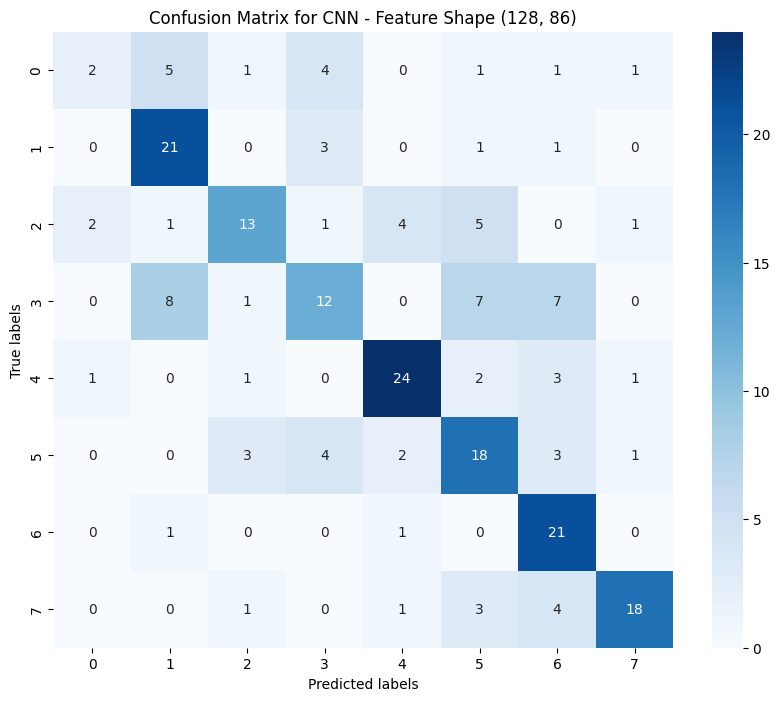

7/7 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     neutral       0.40      0.13      0.20        15
        calm       0.58      0.81      0.68        26
       happy       0.65      0.48      0.55        27
         sad       0.50      0.34      0.41        35
       angry       0.75      0.75      0.75        32
     fearful       0.49      0.58      0.53        31
     disgust       0.53      0.91      0.67        23
   surprised       0.82      0.67      0.73        27

    accuracy                           0.60       216
   macro avg       0.59      0.58      0.56       216
weighted avg       0.60      0.60      0.58       216



In [ ]:
#Confusion matrix, table of Precision, Recall, and F1 Score
# Load the best saved model
saved_model = load_model('best_model_cnn_86')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test86)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 86)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test86)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test86, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

## CNN (43)

In [ ]:
def cnn_ADAM_43():
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train43.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(16))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))  # 8-class classification problem

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Ba  (None, 128, 43, 1)        4         
 tchNormalization)                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 43, 64)       640       
                                                                 
 batch_normalization_13 (Ba  (None, 128, 43, 64)       256       
 tchNormalization)                                               
                                                                 
 elu_12 (ELU)                (None, 128, 43, 64)       0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 21, 64)        0         
 ng2D)                                                           
                                                      

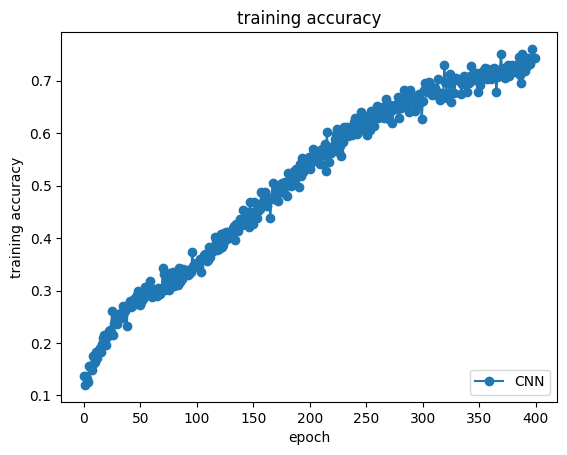

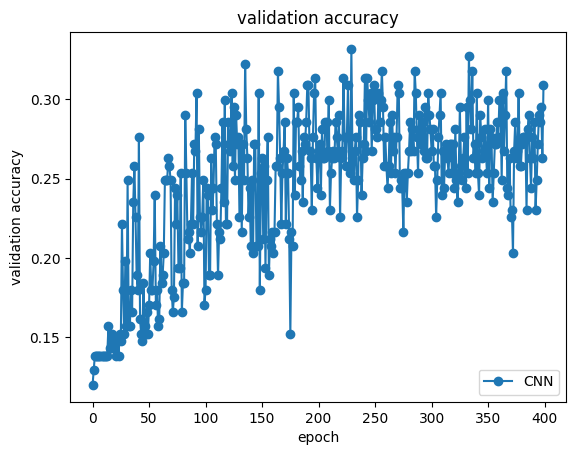

7/7 [==============================] - 1s 68ms/step - loss: 2.1046 - accuracy: 0.3426
Test accuracy: 0.34259259700775146


In [ ]:
# create a callback that will save the best model while training
history_activations = dict()
batch_size = 32
epochs = 400

save_best_model = ModelCheckpoint('best_model_cnn_43', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  cnn_ADAM_43()
history = model.fit(X_train43, y_train43, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val43, y_val43), shuffle=True,
                    callbacks=[save_best_model])

# Plot training accuracy
plt.plot(history.history['accuracy'], 'o-', label='CNN')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy

plt.plot(history.history['val_accuracy'], 'o-', label='CNN')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set/
saved_model = load_model('best_model_cnn_43')
scores = saved_model.evaluate(X_test43, y_test43, verbose=1)
print('Test accuracy: {}'.format(scores[1]))

7/7 [==============================] - 0s 5ms/step


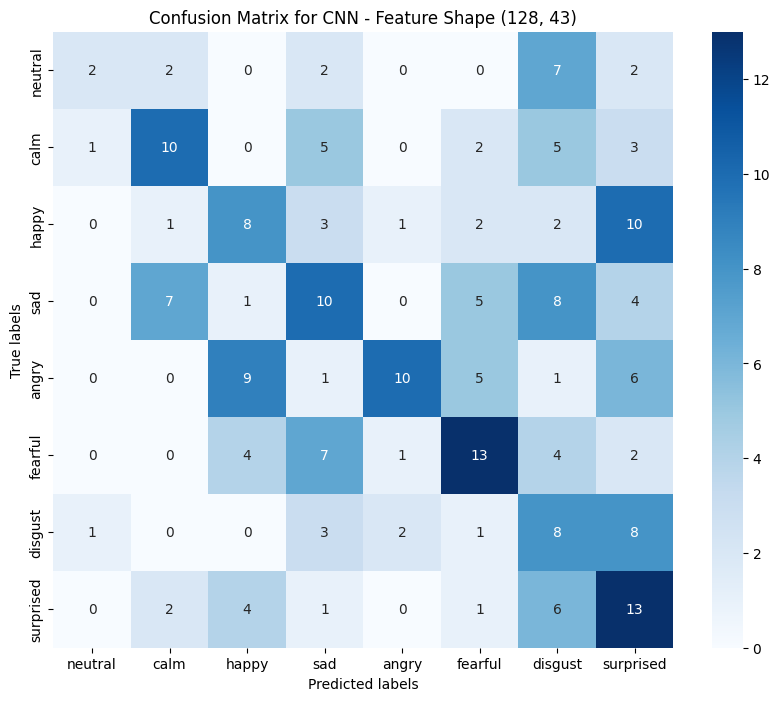

7/7 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

     neutral       0.50      0.13      0.21        15
        calm       0.45      0.38      0.42        26
       happy       0.31      0.30      0.30        27
         sad       0.31      0.29      0.30        35
       angry       0.71      0.31      0.43        32
     fearful       0.45      0.42      0.43        31
     disgust       0.20      0.35      0.25        23
   surprised       0.27      0.48      0.35        27

    accuracy                           0.34       216
   macro avg       0.40      0.33      0.34       216
weighted avg       0.40      0.34      0.35       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_cnn_43')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test43)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test43, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 43)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test43)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# LSTM

# LSTM (347)

In [ ]:
X_train.shape

(1007, 128, 347, 1)

In [ ]:
def base_LSTM(X_train_shape):
    model = Sequential()

    model.add(TimeDistributed(Flatten(), input_shape=X_train_shape))

    # Increase dropout and adjust LSTM units if necessary
    model.add(Bidirectional(LSTM(24, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

    model.add(GlobalAveragePooling1D())

    # Dense layer with L2 regularization
    model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 128, 347)          0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 128, 48)           71424     
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 48)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 392       
                                                                 
Total params: 71816 (280.53 KB)
Trainable params: 71816 (280.53 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

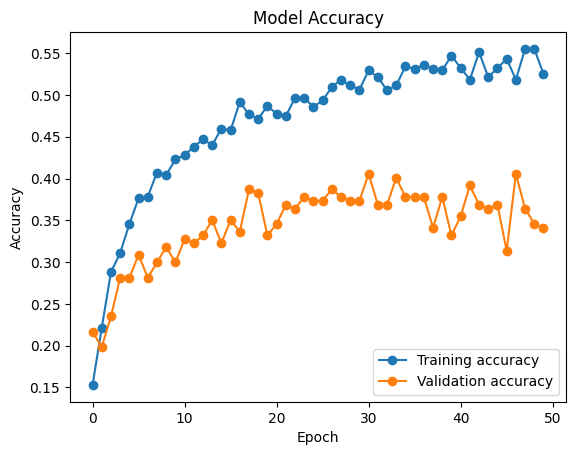

7/7 [==============================] - 1s 66ms/step - loss: 2.0097 - accuracy: 0.3796
Test accuracy: 0.37962964177131653


In [ ]:
# Training the model
batch_size = 32
epochs = 50
save_best_model = ModelCheckpoint('best_model_LSTM_347', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_LSTM(X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model_LSTM = load_model('best_model_LSTM_347')
scores = saved_model_LSTM.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', scores[1])


7/7 [==============================] - 2s 100ms/step


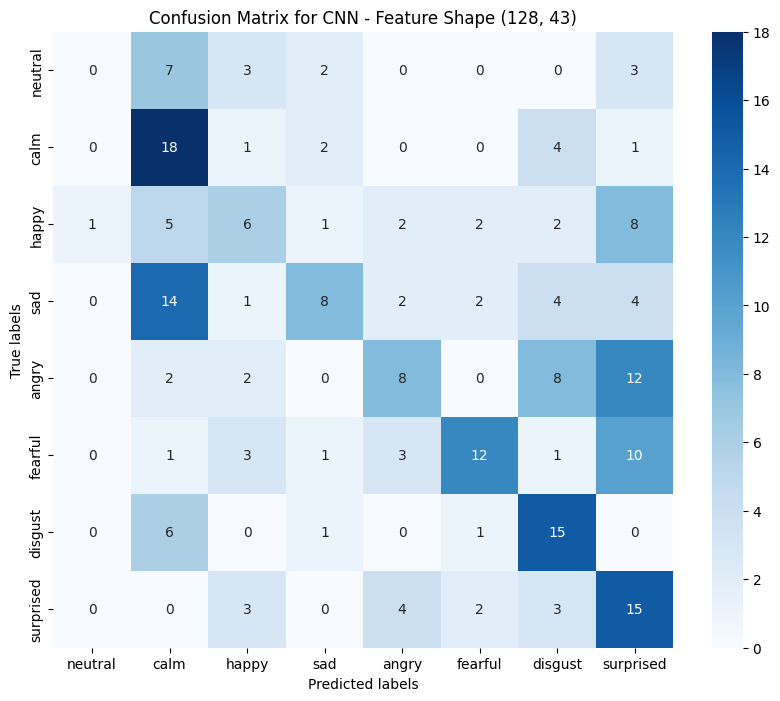

7/7 [==============================] - 1s 102ms/step
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        15
        calm       0.34      0.69      0.46        26
       happy       0.32      0.22      0.26        27
         sad       0.53      0.23      0.32        35
       angry       0.42      0.25      0.31        32
     fearful       0.63      0.39      0.48        31
     disgust       0.41      0.65      0.50        23
   surprised       0.28      0.56      0.38        27

    accuracy                           0.38       216
   macro avg       0.37      0.37      0.34       216
weighted avg       0.40      0.38      0.35       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_LSTM_347')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 347)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# LSTM(173)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 128, 173)          0         
 stributed)                                                      
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 48)           38016     
 onal)                                                           
                                                                 
 global_average_pooling1d_3  (None, 48)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 8)                 392       
                                                                 
Total params: 38408 (150.03 KB)
Trainable params: 38408 (150.03 KB)
Non-trainable params: 0 (0.00 Byte)
________________

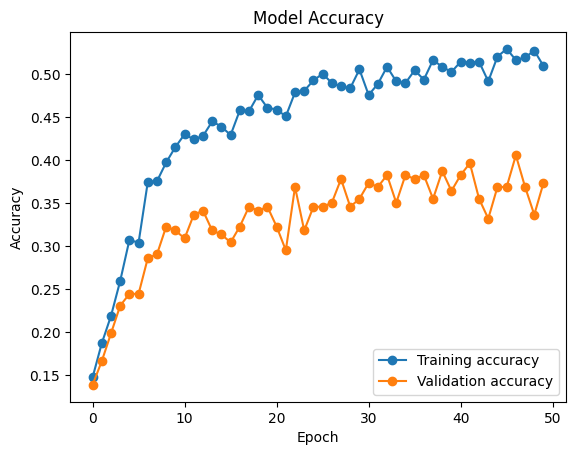

7/7 [==============================] - 1s 45ms/step - loss: 1.9977 - accuracy: 0.3611
Test accuracy: 0.3611111044883728


In [ ]:
# Training the model
batch_size = 32
epochs = 50
save_best_model = ModelCheckpoint('best_model_LSTM_173', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_LSTM(X_train173.shape[1:])
history = model.fit(X_train173, y_train173, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val173, y_val173), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model_LSTM = load_model('best_model_LSTM_173')
scores = saved_model_LSTM.evaluate(X_test173, y_test173, verbose=1)
print('Test accuracy:', scores[1])


7/7 [==============================] - 1s 43ms/step


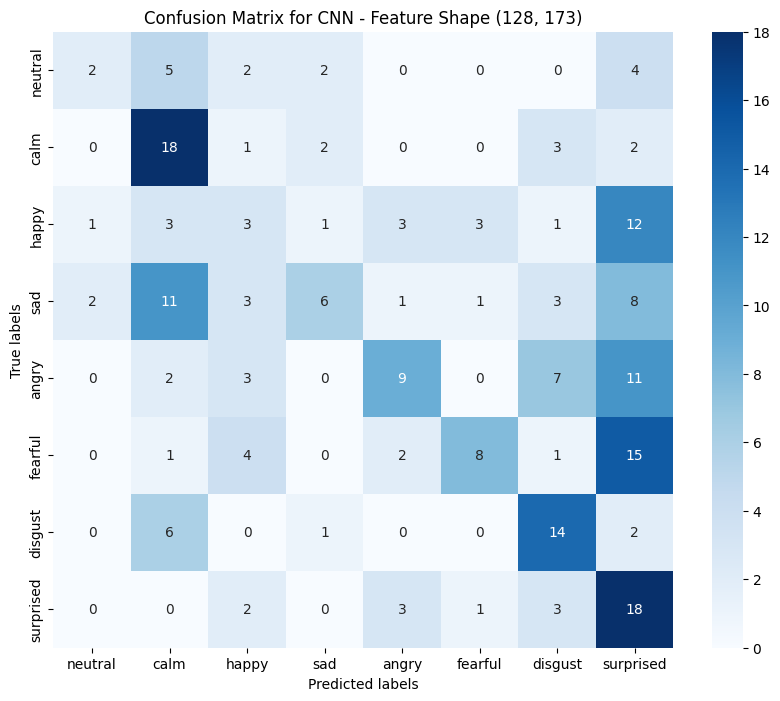

7/7 [==============================] - 0s 43ms/step
              precision    recall  f1-score   support

     neutral       0.40      0.13      0.20        15
        calm       0.39      0.69      0.50        26
       happy       0.17      0.11      0.13        27
         sad       0.50      0.17      0.26        35
       angry       0.50      0.28      0.36        32
     fearful       0.62      0.26      0.36        31
     disgust       0.44      0.61      0.51        23
   surprised       0.25      0.67      0.36        27

    accuracy                           0.36       216
   macro avg       0.41      0.37      0.34       216
weighted avg       0.42      0.36      0.34       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_LSTM_173')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test173)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 173)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test173)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# LSTM (86)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 128, 86)           0         
 stributed)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 48)           21312     
 onal)                                                           
                                                                 
 global_average_pooling1d_1  (None, 48)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 8)                 392       
                                                                 
Total params: 21704 (84.78 KB)
Trainable params: 21704 (84.78 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

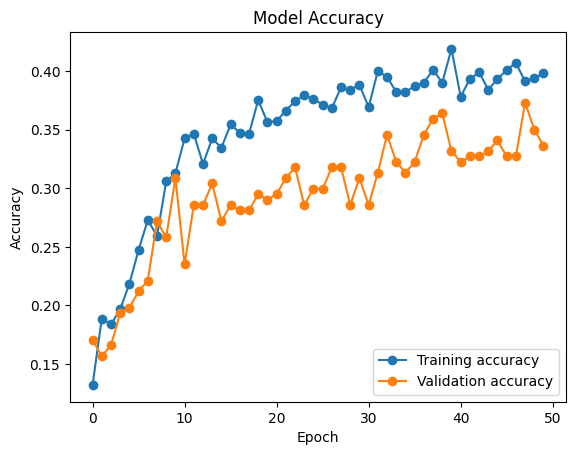

7/7 [==============================] - 1s 38ms/step - loss: 1.9794 - accuracy: 0.3750
Test accuracy: 0.375


In [ ]:
# Training the model
batch_size = 32
epochs = 50
save_best_model = ModelCheckpoint('best_model_LSTM_86', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_LSTM(X_train86.shape[1:])
history = model.fit(X_train86, y_train86, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val86, y_val86), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model_LSTM = load_model('best_model_LSTM_86')
scores = saved_model_LSTM.evaluate(X_test86, y_test86, verbose=1)
print('Test accuracy:', scores[1])


7/7 [==============================] - 1s 59ms/step


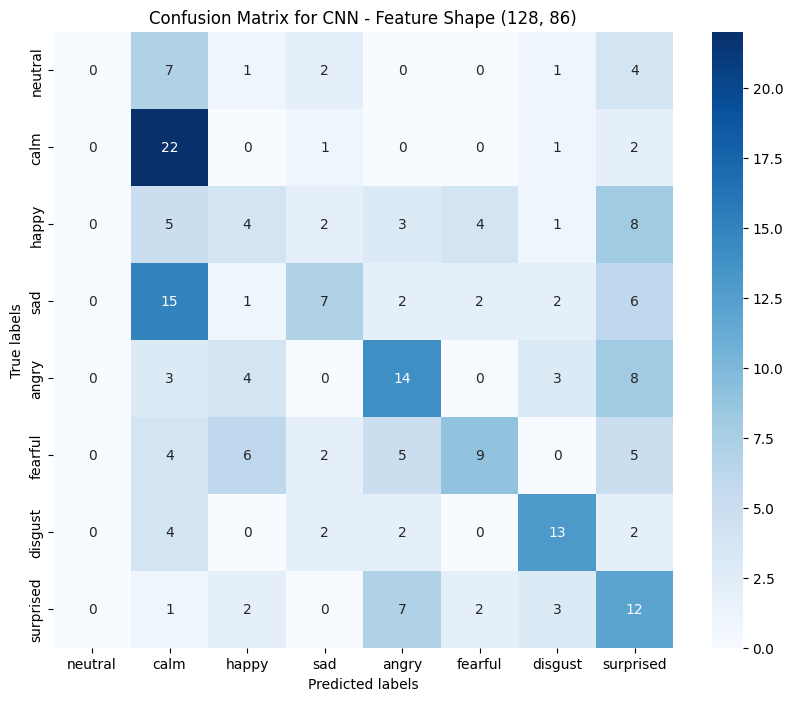

7/7 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        15
        calm       0.36      0.85      0.51        26
       happy       0.22      0.15      0.18        27
         sad       0.44      0.20      0.27        35
       angry       0.42      0.44      0.43        32
     fearful       0.53      0.29      0.38        31
     disgust       0.54      0.57      0.55        23
   surprised       0.26      0.44      0.32        27

    accuracy                           0.38       216
   macro avg       0.35      0.37      0.33       216
weighted avg       0.37      0.38      0.34       216



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the best saved model
saved_model = load_model('best_model_LSTM_86')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test86)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test86, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 86)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test86)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test86, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# LSTM (43)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 128, 43)           0         
 stributed)                                                      
                                                                 
 bidirectional_5 (Bidirecti  (None, 128, 48)           13056     
 onal)                                                           
                                                                 
 global_average_pooling1d_4  (None, 48)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 8)                 392       
                                                                 
Total params: 13448 (52.53 KB)
Trainable params: 13448 (52.53 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

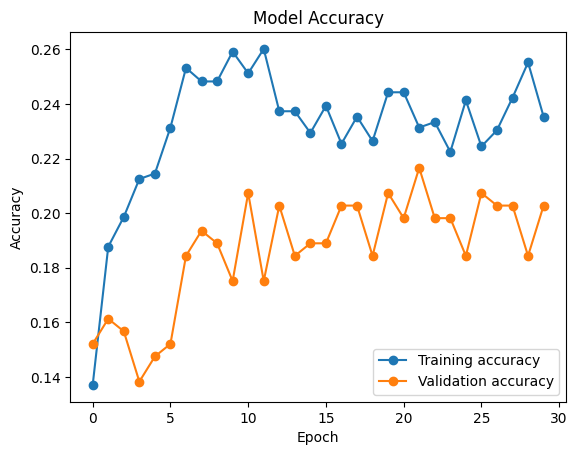

7/7 [==============================] - 1s 71ms/step - loss: 2.1582 - accuracy: 0.2130
Test accuracy: 0.21296297013759613


In [ ]:
# Training the model
batch_size = 32
epochs = 30
save_best_model = ModelCheckpoint('best_model_LSTM_43', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  base_LSTM(X_train43.shape[1:])
history = model.fit(X_train43, y_train43, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val43, y_val43), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model_LSTM = load_model('best_model_LSTM_43')
scores = saved_model_LSTM.evaluate(X_test43, y_test43, verbose=1)
print('Test accuracy:', scores[1])

7/7 [==============================] - 1s 32ms/step


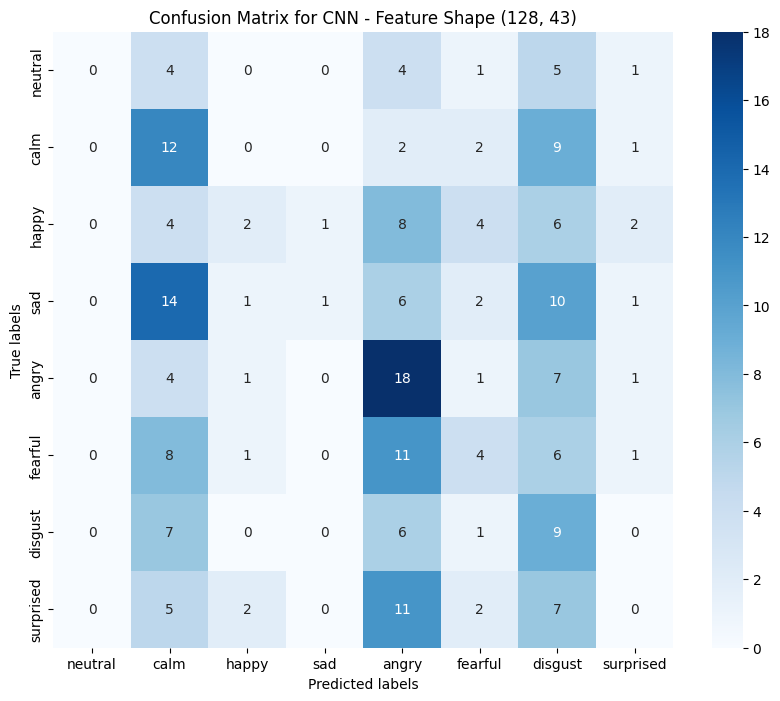

7/7 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        15
        calm       0.21      0.46      0.29        26
       happy       0.29      0.07      0.12        27
         sad       0.50      0.03      0.05        35
       angry       0.27      0.56      0.37        32
     fearful       0.24      0.13      0.17        31
     disgust       0.15      0.39      0.22        23
   surprised       0.00      0.00      0.00        27

    accuracy                           0.21       216
   macro avg       0.21      0.21      0.15       216
weighted avg       0.23      0.21      0.16       216



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the best saved model
saved_model = load_model('best_model_LSTM_43')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test43)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test43, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 43)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test43)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# CRNN

# CRNN(347)

In [14]:
def crnn_model(input_shape):
    model = Sequential()

    model.add(BatchNormalization(input_shape=input_shape))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 5)))
    model.add(Dropout(0.25))

    # Preparing the output of CNN to feed into RNN
    model.add(TimeDistributed(Flatten()))  # Use TimeDistributed to flatten each frame separately

    # RNN layers
    model.add(Bidirectional(LSTM(24, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [15]:
model =  crnn_model(X_train.shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 128, 347, 1)       4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 347, 64)      640       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 347, 64)      256       
 chNormalization)                                                
                                                                 
 elu (ELU)                   (None, 128, 347, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 173, 64)       0         
 D)                                                              
                                                        

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 4.8591 - accuracy: 0.1212
Epoch 1: val_accuracy improved from -inf to 0.11060, saving model to best_model_crnn_347
32/32 [==============================] - 44s 786ms/step - loss: 4.8591 - accuracy: 0.1212 - val_loss: 4.4144 - val_accuracy: 0.1106
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 4.1509 - accuracy: 0.1301
Epoch 2: val_accuracy did not improve from 0.11060
32/32 [==============================] - 8s 236ms/step - loss: 4.1509 - accuracy: 0.1301 - val_loss: 3.8596 - val_accuracy: 0.0968
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 3.6734 - accuracy: 0.1470
Epoch 3: val_accuracy did not improve from 0.11060
32/32 [==============================] - 8s 237ms/step - loss: 3.6734 - accuracy: 0.1470 - val_loss: 3.4747 - val_accuracy: 0.1014
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 3.3472 - accuracy: 0.1609
Epoch 4: val_accuracy improved from

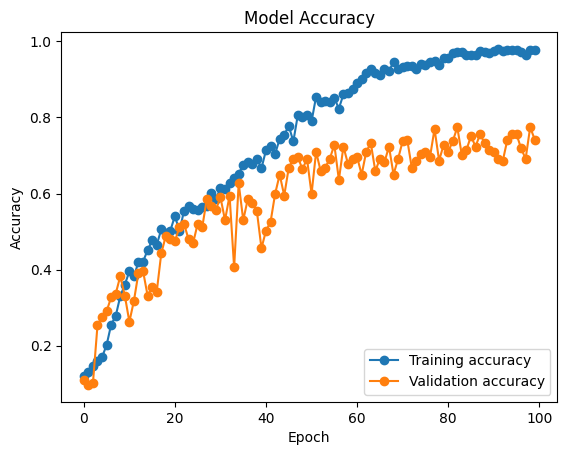

7/7 [==============================] - 2s 250ms/step - loss: 0.9147 - accuracy: 0.7546
Test accuracy: 0.7546296119689941


In [ ]:
# Proceed to train
history_activations = dict()
batch_size = 32
epochs = 100
save_best_model = ModelCheckpoint('best_model_crnn_347', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  crnn_model(X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model = load_model('best_model_crnn_347')
scores = saved_model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', scores[1])


7/7 [==============================] - 1s 37ms/step


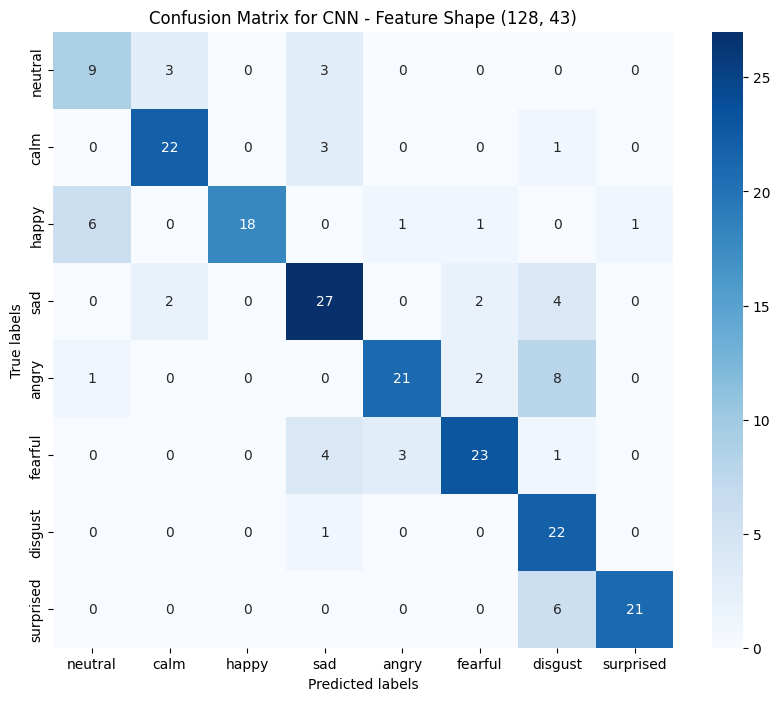

7/7 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

     neutral       0.56      0.60      0.58        15
        calm       0.81      0.85      0.83        26
       happy       1.00      0.67      0.80        27
         sad       0.71      0.77      0.74        35
       angry       0.84      0.66      0.74        32
     fearful       0.82      0.74      0.78        31
     disgust       0.52      0.96      0.68        23
   surprised       0.95      0.78      0.86        27

    accuracy                           0.75       216
   macro avg       0.78      0.75      0.75       216
weighted avg       0.79      0.75      0.76       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_crnn_347')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 347)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# CRNN(173)

In [ ]:
def crnn_model173(input_shape):
    model = Sequential()

    model.add(BatchNormalization(input_shape=input_shape))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 5)))
    model.add(Dropout(0.25))

    # Preparing the output of CNN to feed into RNN
    model.add(TimeDistributed(Flatten()))  # Use TimeDistributed to flatten each frame separately

    # RNN layers
    model.add(Bidirectional(LSTM(24, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 128, 173, 1)       4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 173, 64)      640       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 173, 64)      256       
 chNormalization)                                                
                                                                 
 elu (ELU)                   (None, 128, 173, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 86, 64)        0         
 D)                                                              
                                                        

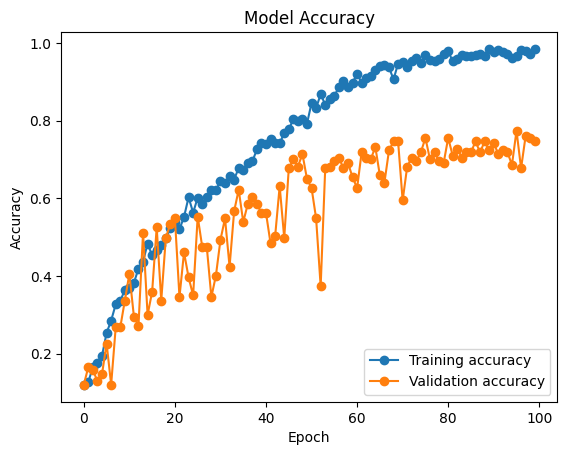

7/7 [==============================] - 1s 132ms/step - loss: 0.7555 - accuracy: 0.7685
Test accuracy: 0.7685185074806213


In [ ]:
# Proceed to train
history_activations = dict()
batch_size = 32
epochs = 100
save_best_model = ModelCheckpoint('best_model_crnn_173', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  crnn_model173(X_train173.shape[1:])
history = model.fit(X_train173, y_train173, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val173, y_val173), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model = load_model('best_model_crnn_173')
scores = saved_model.evaluate(X_test173, y_test173, verbose=1)
print('Test accuracy:', scores[1])

7/7 [==============================] - 1s 20ms/step


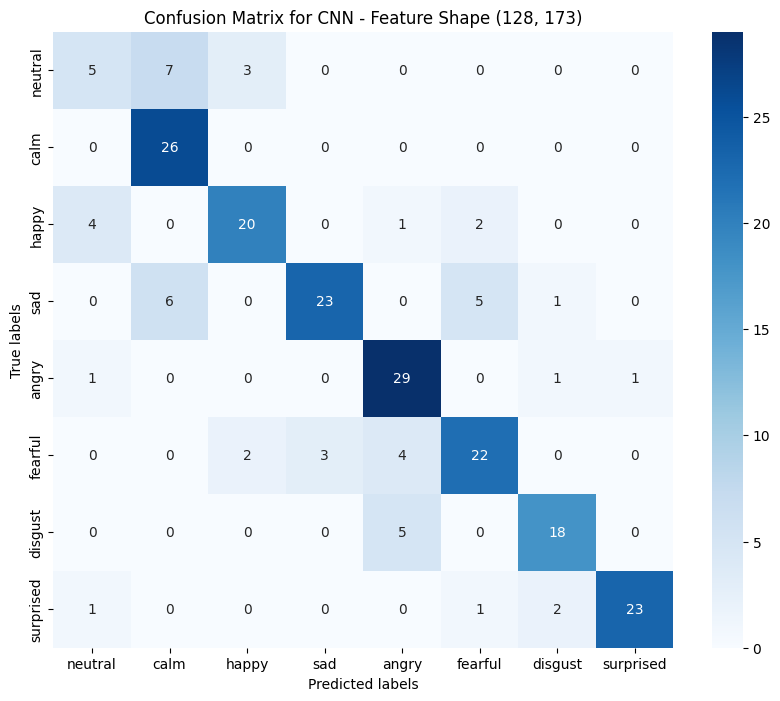

7/7 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

     neutral       0.45      0.33      0.38        15
        calm       0.67      1.00      0.80        26
       happy       0.80      0.74      0.77        27
         sad       0.88      0.66      0.75        35
       angry       0.74      0.91      0.82        32
     fearful       0.73      0.71      0.72        31
     disgust       0.82      0.78      0.80        23
   surprised       0.96      0.85      0.90        27

    accuracy                           0.77       216
   macro avg       0.76      0.75      0.74       216
weighted avg       0.78      0.77      0.76       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_crnn_173')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test173)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 173)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test173)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test173, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# CRNN(86)

In [ ]:
def crnn_model86(input_shape):
    model = Sequential()

    model.add(BatchNormalization(input_shape=input_shape))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    # Preparing the output of CNN to feed into RNN
    model.add(TimeDistributed(Flatten()))  # Use TimeDistributed to flatten each frame separately

    # RNN layers
    model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Ba  (None, 128, 86, 1)        4         
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 86, 64)       640       
                                                                 
 batch_normalization_17 (Ba  (None, 128, 86, 64)       256       
 tchNormalization)                                               
                                                                 
 elu_13 (ELU)                (None, 128, 86, 64)       0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 43, 64)        0         
 ng2D)                                                           
                                                      

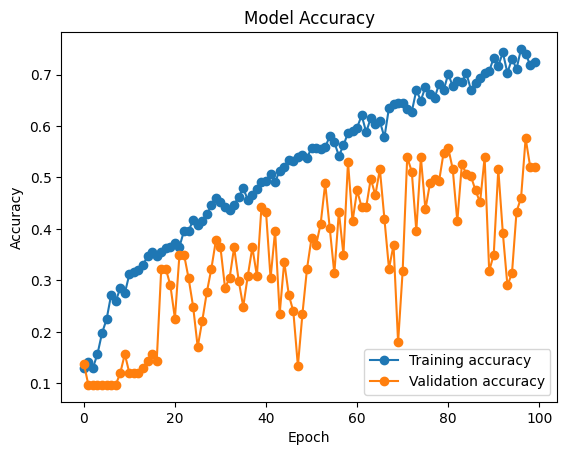

7/7 [==============================] - 1s 79ms/step - loss: 1.2559 - accuracy: 0.5648
Test accuracy: 0.5648148059844971


In [ ]:
# Proceed to train
history_activations = dict()
batch_size = 32
epochs = 100
save_best_model = ModelCheckpoint('best_model_crnn_86', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  crnn_model86(X_train86.shape[1:])
history = model.fit(X_train86, y_train86, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val86, y_val86), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model = load_model('best_model_crnn_86')
scores = saved_model.evaluate(X_test86, y_test86, verbose=1)
print('Test accuracy:', scores[1])

7/7 [==============================] - 1s 11ms/step


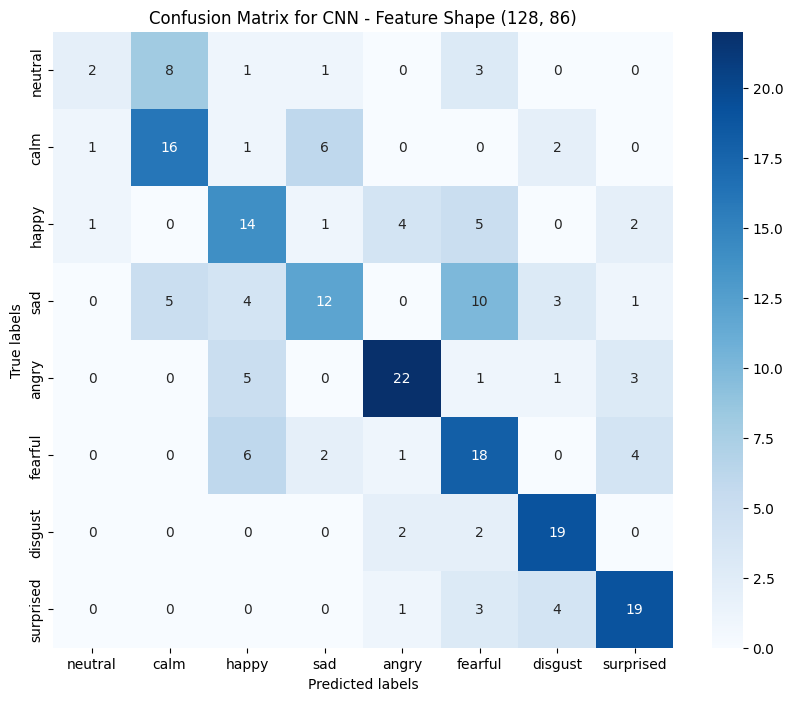

7/7 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

     neutral       0.50      0.13      0.21        15
        calm       0.55      0.62      0.58        26
       happy       0.45      0.52      0.48        27
         sad       0.55      0.34      0.42        35
       angry       0.73      0.69      0.71        32
     fearful       0.43      0.58      0.49        31
     disgust       0.66      0.83      0.73        23
   surprised       0.66      0.70      0.68        27

    accuracy                           0.56       216
   macro avg       0.57      0.55      0.54       216
weighted avg       0.57      0.56      0.55       216



In [ ]:
# Load the best saved model
saved_model = load_model('best_model_crnn_86')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test86)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test86, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 86)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test86)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test86, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)

# CRNN(43)

In [ ]:
def crnn_model43(input_shape):
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_train43.shape[1:]))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))

    # Preparing the output of CNN to feed into RNN
    model.add(TimeDistributed(Flatten()))  # Use TimeDistributed to flatten each frame separately

    # RNN layers
    model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0.4,
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 128, 43, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 43, 64)       640       
                                                                 
 batch_normalization_7 (Bat  (None, 128, 43, 64)       256       
 chNormalization)                                                
                                                                 
 elu_5 (ELU)                 (None, 128, 43, 64)       0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 21, 64)        0         
 g2D)                                                            
                                                      

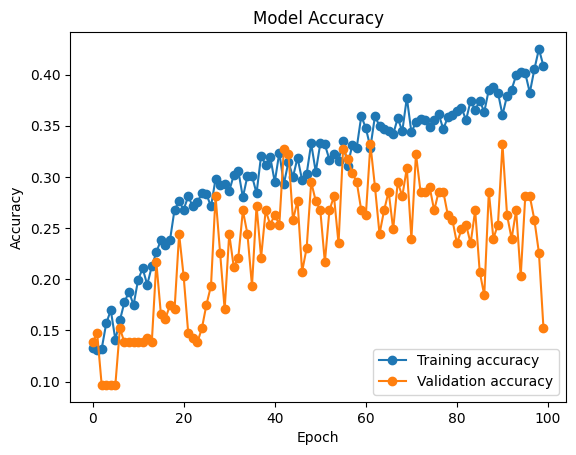

7/7 [==============================] - 1s 69ms/step - loss: 1.7847 - accuracy: 0.3102
Test accuracy: 0.31018519401550293


In [ ]:
batch_size = 32
epochs = 100
save_best_model = ModelCheckpoint('best_model_crnn_43', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
model =  crnn_model43(X_train43.shape[1:])
history = model.fit(X_train43, y_train43, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val43, y_val43), shuffle=True,
                    callbacks=[save_best_model])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved on the test set
saved_model = load_model('best_model_crnn_43')
scores = saved_model.evaluate(X_test43, y_test43, verbose=1)
print('Test accuracy:', scores[1])

7/7 [==============================] - 1s 7ms/step


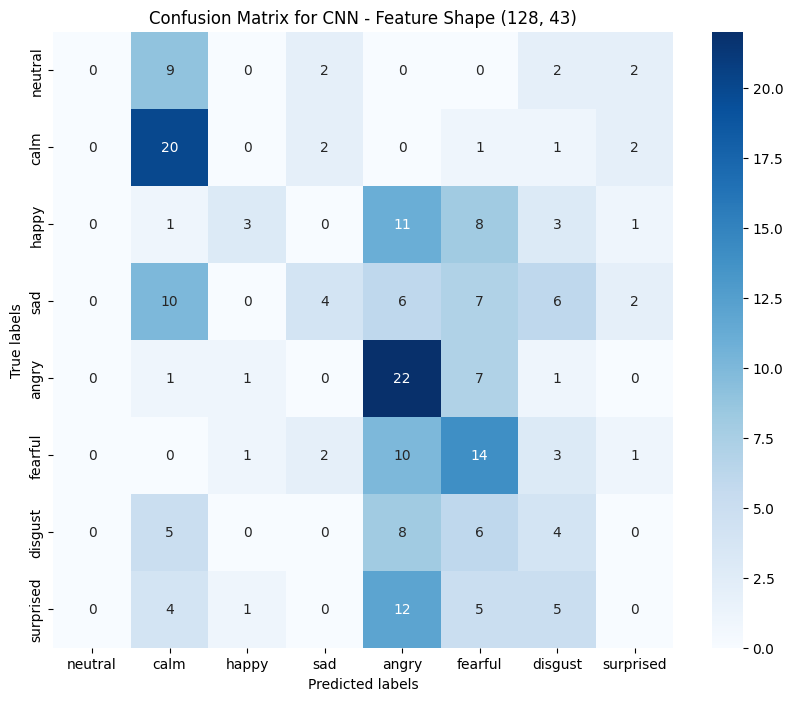

7/7 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        15
        calm       0.40      0.77      0.53        26
       happy       0.50      0.11      0.18        27
         sad       0.40      0.11      0.18        35
       angry       0.32      0.69      0.44        32
     fearful       0.29      0.45      0.35        31
     disgust       0.16      0.17      0.17        23
   surprised       0.00      0.00      0.00        27

    accuracy                           0.31       216
   macro avg       0.26      0.29      0.23       216
weighted avg       0.28      0.31      0.25       216



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the best saved model
saved_model = load_model('best_model_crnn_43')

# Generate predictions for the test set
y_pred = saved_model.predict(X_test43)
# If your labels are one-hot encoded, convert the predictions to label indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test43, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a DataFrame from the confusion matrix with target names as indices and columns

conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for CNN - Feature Shape (128, 43)')
plt.show()


# Generate the predictions as before
y_pred = saved_model.predict(X_test43)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)